### **Install libraries**





In [ ]:
!pip install statsmodels
!pip install pmdarima
!pip install gdown

### **Import libraries**

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import gdown
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
from pmdarima import auto_arima
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

### **Load and observe data**

In [ ]:
url = 'https://drive.google.com/uc?id=1J39j36K5CdeLH1tJDTFLEEIrE64IunaG'
output = 'AEP_hourly.csv'
gdown.download(url, output, quiet=True)

#The file contains hourly electricity consumption
consumption = pd.read_csv("AEP_hourly.csv", parse_dates=[0])
consumption.info()
consumption.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 121273 entries, 0 to 121272
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype         
---  ------    --------------   -----         
 0   Datetime  121273 non-null  datetime64[ns]
 1   AEP_MW    121273 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 1.9 MB


,Datetime,AEP_MW
0,2004-12-31 01:00:00,13478.0
1,2004-12-31 02:00:00,12865.0
2,2004-12-31 03:00:00,12577.0
3,2004-12-31 04:00:00,12517.0
4,2004-12-31 05:00:00,12670.0


### **Calculate and plot *daily* electricity consumption**





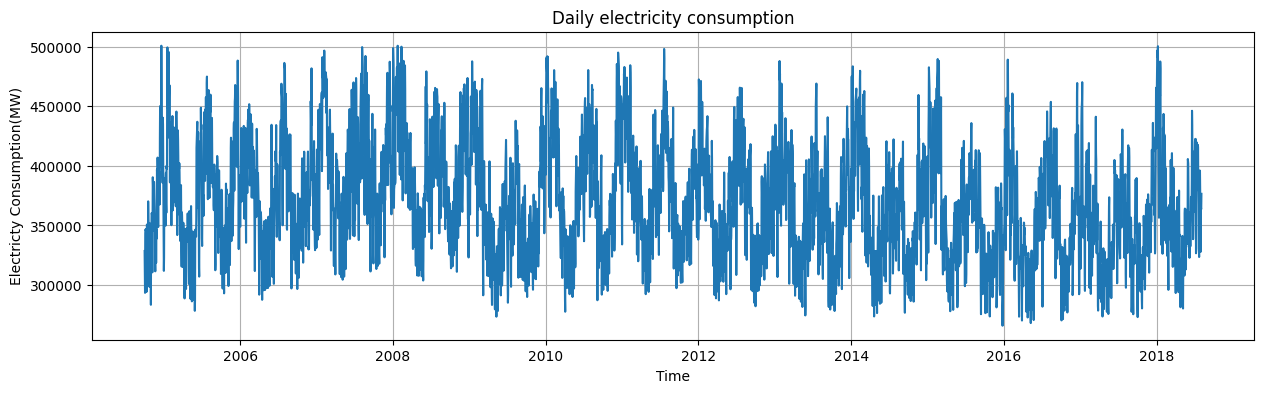

In [ ]:
#Calculate daily electricity consumption
consumption_daily = consumption.groupby(consumption.Datetime.dt.strftime('%d-%m-%Y')).sum(numeric_only=True).reset_index()
consumption_daily["Datetime"] = pd.to_datetime(consumption_daily["Datetime"], dayfirst = True)
consumption_daily.sort_values(by=['Datetime'], inplace = True)

### Detect and eliminate outliers ###
# Calculate the IQR for each column
Q1 = consumption_daily.AEP_MW.quantile(0.25)
Q3 = consumption_daily.AEP_MW.quantile(0.75)
IQR = Q3 - Q1

# Identify outliers
outliers = (consumption_daily.AEP_MW < (Q1 - 1.5 * IQR)) | (consumption_daily.AEP_MW > (Q3 + 1.5 * IQR))

# Drop outliers permanently
consumption_daily = consumption_daily[~outliers]

#Plot daily electricity consumption
plt.figure(figsize = (15,4))
plt.plot(consumption_daily.Datetime, consumption_daily.AEP_MW)
plt.xlabel("Time")
plt.ylabel("Electricty Consumption(MW)")
plt.title("Daily electricity consumption")
plt.grid(True)




### **Compute and plot *monthly* electricity consumption**

,YYYY,MM,AEP_MW
date,,,
2004-10,2004,10,10349073.0
2004-11,2004,11,10677917.0
2004-12,2004,12,12452864.0
2005-01,2005,01,12735114.0
2005-02,2005,02,11085745.0
...,...,...,...
2018-04,2018,04,9820256.0
2018-05,2018,05,10503052.0
2018-06,2018,06,11019780.0


Text(0.5, 1.0, 'Monthly electricity consumption')

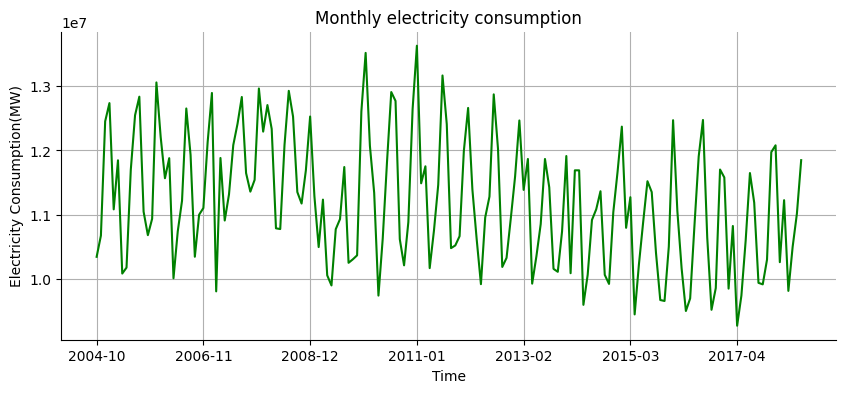

In [ ]:
# Calculate Monthly consumption
consumption_daily.tail()
consumption_daily['MM'] = consumption_daily.Datetime.dt.strftime('%m')
consumption_daily['YYYY'] = consumption_daily.Datetime.dt.strftime('%Y')
consumption_monthly = consumption_daily.groupby(["YYYY","MM"]).sum(numeric_only=True).reset_index()
consumption_monthly['date'] = consumption_monthly['YYYY'] + "-" + consumption_monthly['MM']
consumption_monthly.set_index('date', inplace=True)
display(consumption_monthly)

### Detect and eliminate outliers ###
# Calculate the IQR for each column
Q1 = consumption_monthly.AEP_MW.quantile(0.25)
Q3 = consumption_monthly.AEP_MW.quantile(0.75)
IQR = Q3 - Q1

# Identify outliers
outliers = (consumption_monthly.AEP_MW < (Q1 - 1.5 * IQR)) | (consumption_monthly.AEP_MW > (Q3 + 1.5 * IQR))

# Drop outliers permanently
consumption_monthly = consumption_monthly[~outliers]

consumption_monthly['AEP_MW'].plot(kind='line', figsize=(10, 4), title='AEP_MW', color='green')
plt.gca().spines[['top', 'right']].set_visible(False)
plt.grid(True)
plt.xlabel('Time')
plt.ylabel('Electricity Consumption(MW)')
plt.title('Monthly electricity consumption')

### **ACF plot of the monthly electricity consumption**

Text(0.5, 1.0, 'Autocorrelation Function (ACF) Plot')

<Figure size 2000x600 with 0 Axes>

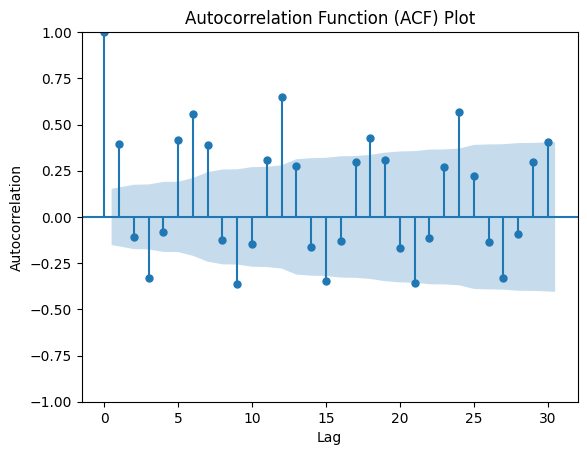

In [ ]:
plt.figure(figsize=(20, 6))
plot_acf(consumption_monthly["AEP_MW"], lags=30)
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.title('Autocorrelation Function (ACF) Plot')

#Peaks at regular intervals indicate seasonality


### **Compare monthly electricity consumption of 2005, 2010 and 2015**

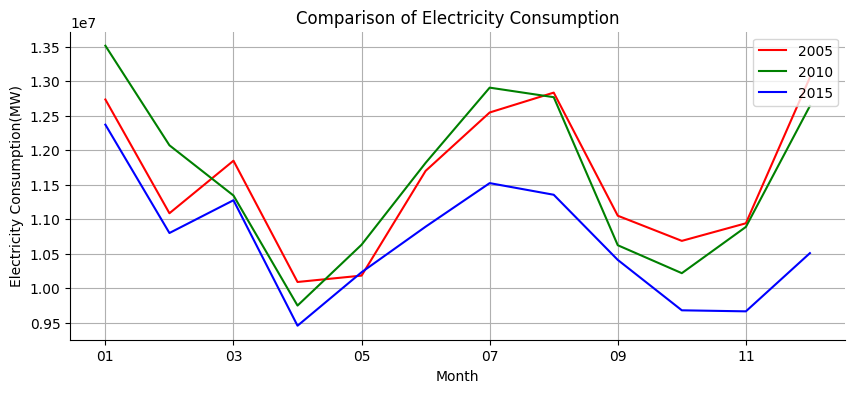

In [ ]:
consumption_monthly_2005 = consumption_monthly[consumption_monthly.YYYY == '2005']
consumption_monthly_2010 = consumption_monthly[consumption_monthly.YYYY == '2010']
consumption_monthly_2015 = consumption_monthly[consumption_monthly.YYYY == '2015']

consumption_monthly_2005.set_index('MM')['AEP_MW'].plot(kind='line', figsize=(10, 4), title='AEP_MW', color='red')
consumption_monthly_2010.set_index('MM')['AEP_MW'].plot(kind='line', figsize=(10, 4), title='AEP_MW', color='green')
consumption_monthly_2015.set_index('MM')['AEP_MW'].plot(kind='line', figsize=(10, 4), title='AEP_MW', color='blue')
plt.gca().spines[['top', 'right']].set_visible(False)
plt.legend(["2005","2010","2015"], loc='upper right')
plt.xlabel('Month')
plt.ylabel('Electricity Consumption(MW)')
plt.title('Comparison of Electricity Consumption')
plt.grid(True)

### **Decompose monthly electricity consumption into three components(seasonal, trend and residual)**

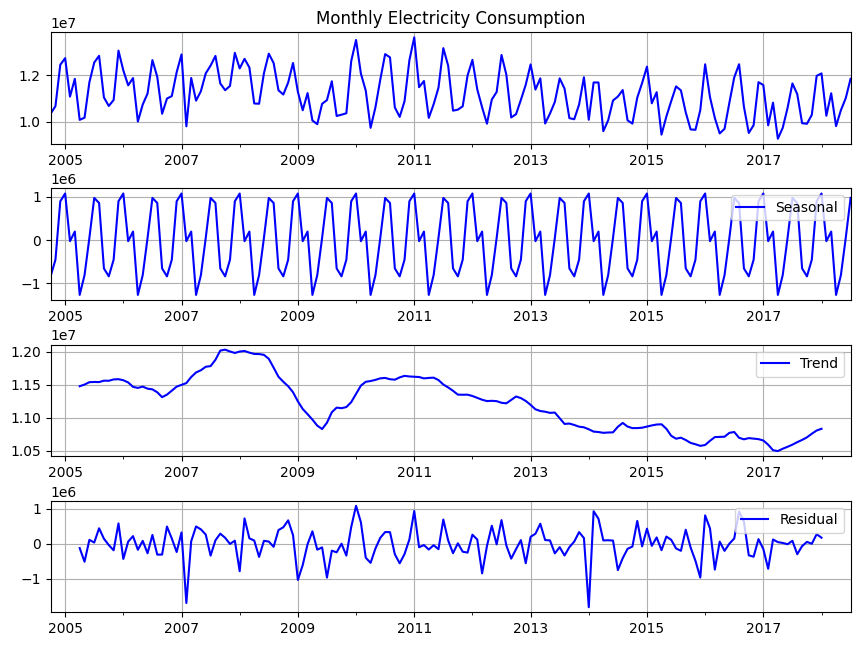

In [ ]:
consumption_monthly.index = pd.to_datetime(consumption_monthly.index)
consumption_monthly = consumption_monthly.rename_axis(None)
consumption_monthly.drop(columns = ["MM","YYYY"], inplace=True)

decompose = seasonal_decompose(consumption_monthly, model='additive')

plt.figure(figsize = (10,4))
plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=3.0, wspace=0.4, hspace=0.4)

plt.subplot(4, 1, 1)
consumption_monthly["AEP_MW"].set_axis(consumption_monthly.index).plot(kind='line', figsize=(10, 2), title='Monthly Electricity Consumption', color='blue')
plt.grid(True)

plt.subplot(4, 1, 2)
decompose.seasonal.plot(kind='line', figsize=(10, 2), color='blue')
plt.grid(True)
plt.legend(["Seasonal"],loc="upper right")

plt.subplot(4, 1, 3)
decompose.trend.plot(kind='line', figsize=(10, 2), color='blue')
plt.legend(["Trend"],loc="upper right")
plt.grid(True)

plt.subplot(4, 1, 4)
decompose.resid.plot(kind='line', figsize=(10, 2), color='blue')
plt.legend(["Residual"],loc="upper right")
plt.grid(True)

### **Time Series Forecasting**

In [ ]:
#Find best ARIMA model for this dataset
best_model = auto_arima(consumption_monthly["AEP_MW"][:-24], seasonal=True, m=12, trace=True, suppress_warnings=True)

# Get the parameters of the fitted ARIMA model
print(best_model.summary())

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=inf, Time=3.29 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=4322.936, Time=0.10 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=4299.232, Time=0.21 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=4307.895, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=4320.954, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=4324.672, Time=0.06 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=4288.123, Time=0.32 sec
 ARIMA(1,1,0)(2,0,1)[12] intercept   : AIC=4283.400, Time=0.56 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=4282.189, Time=0.17 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=4308.830, Time=0.11 sec
 ARIMA(1,1,0)(1,0,2)[12] intercept   : AIC=4283.529, Time=0.52 sec
 ARIMA(1,1,0)(0,0,2)[12] intercept   : AIC=4295.140, Time=0.34 sec
 ARIMA(1,1,0)(2,0,2)[12] intercept   : AIC=4284.336, Time=1.22 sec
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=4282.431, Time=0.14 sec
 ARIMA(2,1,0)(1,0,1)[12]

In [ ]:
#Parameters of the best model
p,d,q,P,D,Q,s = [4,1,0,1,0,1,12]

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_date

1/1 [==============================] - 1s 674ms/step


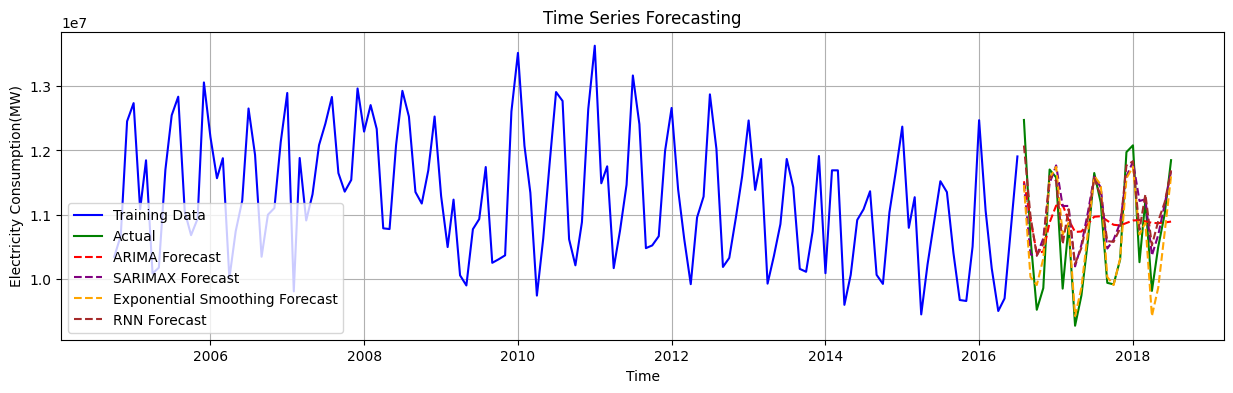

In [ ]:
# Split the data into training and testing sets
#train_data = consumption_monthly.iloc[:-24]  # Use all but the last 24 months for training
#test_data = consumption_monthly.iloc[-24:]   # Use the last 24 months for testing

# Normalize the data (optional)
scaler = MinMaxScaler()
consumption_monthly['AEP_MW_normalized'] = scaler.fit_transform(consumption_monthly[['AEP_MW']])

# Define training and testing data
train_data = consumption_monthly.iloc[:-24]  # Use all but the last 24 months for training
test_data = consumption_monthly.iloc[-24:]   # Use the last 24 months for testing

# ARIMA model
arima_model = ARIMA(train_data['AEP_MW'], order=(p,d,q))
arima_results = arima_model.fit()
arima_forecast = arima_results.forecast(steps=24)

# SARIMAX model
sarimax_model = SARIMAX(train_data['AEP_MW'], order=(p,d,q), seasonal_order=(P,D,Q,s))
sarimax_results = sarimax_model.fit()
sarimax_forecast = sarimax_results.forecast(steps=24)

# Exponential Smoothing model
exp_smoothing_model = ExponentialSmoothing(train_data['AEP_MW'], seasonal='add', seasonal_periods=12)
exp_smoothing_results = exp_smoothing_model.fit()
exp_smoothing_forecast = exp_smoothing_results.forecast(steps=24)

# RNN model
# Define the RNN model
model = Sequential([
    LSTM(units=64, input_shape=(1, 1)),
    Dense(units=1)
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Prepare training data (reshape and scale)
X_train = np.array(train_data['AEP_MW_normalized']).reshape(-1, 1, 1)
y_train = np.array(train_data['AEP_MW_normalized'])

# Train the model
model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0)

# Prepare testing data (reshape and scale)
X_test = np.array(test_data['AEP_MW_normalized']).reshape(-1, 1, 1)

# Make predictions for the future 24 months
rnn_forecast_normalized = model.predict(X_test)

# Inverse scaling to get the actual values
rnn_forecast = scaler.inverse_transform(predicted_data_normalized)

# Plot the results
plt.figure(figsize=(15, 4))
plt.plot(train_data.index, train_data['AEP_MW'], label='Training Data', color='blue')
plt.plot(test_data.index, test_data['AEP_MW'], label='Actual', color='green')
plt.plot(test_data.index, arima_forecast, label='ARIMA Forecast', color='red', linestyle='--')
plt.plot(test_data.index, sarimax_forecast, label='SARIMAX Forecast', color='purple', linestyle='--')
plt.plot(test_data.index, exp_smoothing_forecast, label='Exponential Smoothing Forecast', color='orange', linestyle='--')
plt.plot(test_data.index, rnn_forecast, label='RNN Forecast', color='brown', linestyle='--')

plt.xlabel('Time')
plt.ylabel('Electricity Consumption(MW)')
plt.title('Time Series Forecasting')
plt.legend()
plt.grid(True)


### **Calculate prediction errors**

In [ ]:
# Calculate prediction errors for ARIMA
arima_mae = mean_absolute_error(test_data['AEP_MW'], arima_forecast)
arima_mse = mean_squared_error(test_data['AEP_MW'], arima_forecast)
arima_rmse = np.sqrt(arima_mse)

# Calculate prediction errors for SARIMAX
sarimax_mae = mean_absolute_error(test_data['AEP_MW'], sarimax_forecast)
sarimax_mse = mean_squared_error(test_data['AEP_MW'], sarimax_forecast)
sarimax_rmse = np.sqrt(sarimax_mse)

# Calculate prediction errors for Exponential Smoothing
exp_smoothing_mae = mean_absolute_error(test_data['AEP_MW'], exp_smoothing_forecast)
exp_smoothing_mse = mean_squared_error(test_data['AEP_MW'], exp_smoothing_forecast)
exp_smoothing_rmse = np.sqrt(exp_smoothing_mse)

rnn_forecast = predicted_data
# Calculate prediction errors for RNN
rnn_mae = mean_absolute_error(test_data['AEP_MW'], rnn_forecast)
rnn_mse = mean_squared_error(test_data['AEP_MW'], rnn_forecast)
rnn_rmse = np.sqrt(rnn_mse)

# Create a DataFrame to store the prediction error information
data = {
    'Method Used': ['ARIMA', 'SARIMAX', 'Exponential Smoothing', 'RNN'],
    'MAE': [arima_mae, sarimax_mae, exp_smoothing_mae, rnn_mae],
    'MSE': [arima_mse, sarimax_mse, exp_smoothing_mse, rnn_mse],
    'RMSE': [arima_rmse, sarimax_rmse, exp_smoothing_rmse, rnn_rmse]
}

error_df = pd.DataFrame(data)

# Display the DataFrame
display(error_df)


,Method Used,MAE,MSE,RMSE
0,ARIMA,713341.800460,6.530256e+11,808100.010544
1,SARIMAX,488851.033657,3.527062e+11,593890.704614
2,Exponential Smoothing,315465.546806,1.632207e+11,404005.772505
3,RNN,412162.000000,2.414095e+11,491334.380274




### **Forecast electricity consumption for the next 24 months**

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


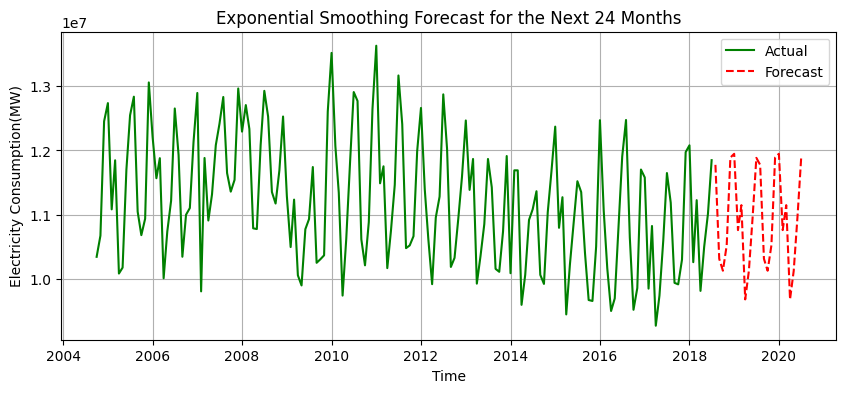

In [ ]:
### Use exponential smoothing,as it gave best results ###

# Fit the Exponential Smoothing model to the entire dataset
exp_smoothing_model = ExponentialSmoothing(consumption_monthly['AEP_MW'], seasonal='add', seasonal_periods=12)
exp_smoothing_results = exp_smoothing_model.fit()

# Make predictions for the next 24 months
next_24_months = exp_smoothing_results.forecast(steps=24)

# Plot the results
plt.figure(figsize=(10, 4))
plt.plot(consumption_monthly.index, consumption_monthly['AEP_MW'], label='Actual', color='green')
plt.plot(next_24_months.index, next_24_months, label='Forecast', color='red', linestyle='--')
plt.xlabel('Time')
plt.ylabel('Electricity Consumption(MW)')
plt.title('Exponential Smoothing Forecast for the Next 24 Months')
plt.legend()
plt.grid(True)
